First few lines of raw data:
+,S10,		tactagcaatacgcttgcgttcggtggttaagtatgtataatgcgcgggcttgtcgt
+,AMPC,		tgctatcctgacagttgtcacgctgattggtgtcgttacaatctaacgcatcgccaa
+,AROH,		gtactagagaactagtgcattagcttatttttttgttatcatgctaaccacccggcg
+,DEOP2,	aattgtgatgtgtatcgaagtgtgttgcggagtagatgttagaatactaacaaactc
+,LEU1_TRNA,	tcgataattaactattgacgaaaagctgaaaaccactagaatgcgcctccgtggtag
+,MALEFG,	aggggcaaggaggatggaaagaggttgccgtataaagaaactagagtccgtttaggt
+,MALK,		cagggggtggaggatttaagccatctcctgatgacgcatagtcagcccatcatgaat
+,RECA,		tttctacaaaacacttga

First few processed data points:
['+,S10,', 'TACTAGCAATACGCTTGCGTTCGGTGGTTAAGTATGTATAATGCGCGGGCTTGTCGT']
['+,AMPC,', 'TGCTATCCTGACAGTTGTCACGCTGATTGGTGTCGTTACAATCTAACGCATCGCCAA']
['+,AROH,', 'GTACTAGAGAACTAGTGCATTAGCTTATTTTTTTGTTATCATGCTAACCACCCGGCG']
['+,DEOP2,', 'AATTGTGATGTGTATCGAAGTGTGTTGCGGAGTAGATGTTAGAATACTAACAAACTC']
['+,LEU1_TRNA,', 'TCGATAATTAACTATTGACGAAAAGCTGAAAACCACTAGAATGCGCCTCCGTGGTAG']

Unique classes in the dataset: {'+,LEU1_TRNA,', '+,RRNG_P1,', '+,

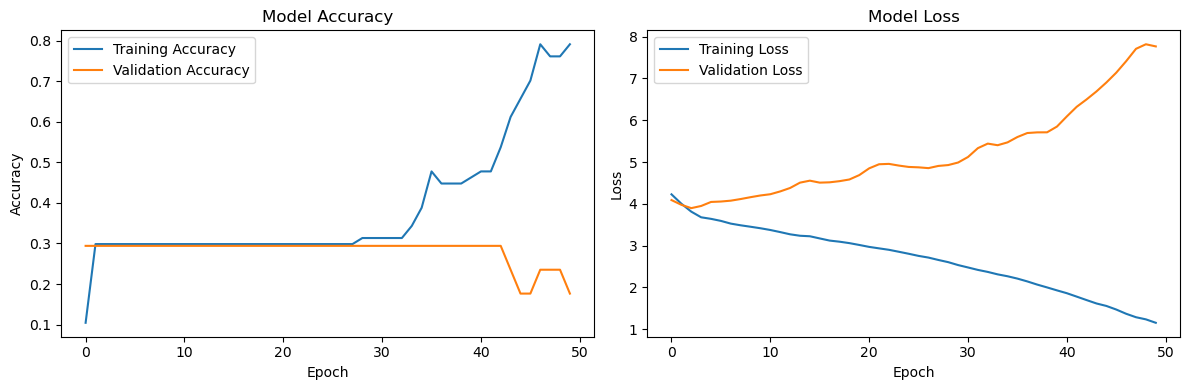

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, Flatten
from tensorflow.keras.utils import to_categorical
import requests

def load_and_preprocess_data(url):
    
    # download data
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to download data: HTTP {response.status_code}")
    
    # print the first few lines of raw data
    print("First few lines of raw data:")
    print(response.text[:500])
    
    lines = response.text.split('\n')
    
    data = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) >= 2:
            label = parts[0]
            sequence = ''.join(parts[1:]).upper()
            if sequence:
                data.append([label, sequence])
    
    if not data:
        raise Exception("No valid data found after preprocessing")
    
    # print the first few data points
    print("\nFirst few processed data points:")
    for i in range(min(5, len(data))):
        print(data[i])
    
    # convert to data frame
    df = pd.DataFrame(data, columns=['class', 'sequence'])
    
    X = df['sequence'].values
    y = df['class'].values
    
    # convert sequences to numerical representation
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1]}
    X_encoded = np.array([
        [mapping[base] for base in seq if base in mapping]
        for seq in X
    ])
    
    # make sure all sequences have same length
    max_length = max(len(seq) for seq in X_encoded)
    X_encoded = np.array([np.pad(seq, ((0, max_length - len(seq)), (0, 0)), 'constant') for seq in X_encoded])
    
    # labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_onehot = to_categorical(y_encoded)
    
    # print unique classes
    unique_classes = set(label for label, _ in data)
    print(f"\nUnique classes in the dataset: {unique_classes}")

    # print a few examples of raw data
    print("\nExamples of raw data:")
    for i in range(min(5, len(data))):
        print(f"Class: {data[i][0]}, Sequence: {data[i][1][:20]}...")  # Print first 20 bases

    # print label encoder classes
    print(f"\nLabel encoder classes: {label_encoder.classes_}")

    return X_encoded, y_onehot, label_encoder



# create the model using functional API
def create_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(32, 3, activation='relu')(inputs)
    x = MaxPooling1D(2)(x)
    x = Conv1D(64, 3, activation='relu')(x)
    x = MaxPooling1D(2)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Main execution
if __name__ == "__main__":
    try:
        # load data
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/molecular-biology/promoter-gene-sequences/promoters.data"
        X_encoded, y_onehot, label_encoder = load_and_preprocess_data(url)
        
        print(f"\nShape of X_encoded: {X_encoded.shape}")
        print(f"Shape of y_onehot: {y_onehot.shape}")
        
        
        X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_onehot, test_size=0.2, random_state=42)
        
        model = create_model(input_shape=(X_train.shape[1], X_train.shape[2]), num_classes=y_onehot.shape[1])
        history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=2)

        # plot training history
        import matplotlib.pyplot as plt
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        plt.savefig('training_history.png')
        print("Training history plot saved as 'training_history.png'")

        # evaluate model
        loss, accuracy = model.evaluate(X_test, y_test)
        print(f"Test accuracy: {accuracy:.2f}")

        # predictions
        sample_sequence = X_test[0:1]
        prediction = model.predict(sample_sequence)
        predicted_class = label_encoder.inverse_transform([np.argmax(prediction)])
        print(f"Predicted class for sample sequence: {predicted_class[0]}")
        print(f"Prediction probabilities: {prediction[0]}")

        # save the model
        model.save('dna_sequence_classifier.keras')

    # error handling
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        import traceback
        traceback.print_exc()